<h1>Image Classifier</h1> 


<h2>Preparation</h2>


In [1]:
# Import the libraries we need to use in this lab

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
import os
from PIL import Image
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import Subset, DataLoader

<h2>Define dataset class</h2>


In [24]:
# Define your dataset class
class Dataset(Dataset):
    # Constructor
    def __init__(self, transform=None, train=True):
        # Directory of the data
        directory = "C:/Users/ASUS/Documents/Coursera/Coursera Specialization/IBM AI Engineering/Intro to Computer Vision and Image Processing/Peer-Graded Assignment/Data/"
        positive = "Stop"
        negative = "NoStop"
        
        # Path of the negative and positive data
        positive_file_path = os.path.join(directory, positive)
        negative_file_path = os.path.join(directory, negative)
        
        # Get the data
        positive_files = [os.path.join(positive_file_path, file) for file in os.listdir(positive_file_path)]
        positive_files.sort()
        negative_files = [os.path.join(negative_file_path, file) for file in os.listdir(negative_file_path)]
        negative_files.sort()
        
        number_of_samples = len(positive_files) + len(negative_files)
        
        self.all_files = [None] * number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 

        self.transform = transform
        
        # Define the target values
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1  # Positive class
        self.Y[1::2] = 0  # Negative class
        
        # Define the train and test dataset
        if train==True:
            self.all_files=self.all_files[0:360]
            self.Y=self.Y[0:360]
            self.len=len(self.all_files)

        else:
            self.all_files=self.all_files[360:]
            self.Y=self.Y[360:]
            self.len=len(self.all_files)

    # Get the length of the dataset
    def __len__(self):
        return self.len

    # Getter to retrieve an image and label pair
    def __getitem__(self, idx):
        image = Image.open(self.all_files[idx]).convert('RGB')  # Ensure all images are RGB
        y = self.Y[idx]

        # If there is a transform, apply it
        if self.transform:
            image = self.transform(image)

        return image, y

<h2>Define CNN model</h2>


In [25]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=32, out_2=64, out_3=64):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=3, padding=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, stride=1, padding=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        
        self.fc1_input_size = out_3 * 18 * 18
        
        self.fc1 = nn.Linear(self.fc1_input_size, 2)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = x.view(-1, self.fc1_input_size)
        x = self.fc1(x)
        return x

<h2>Define criterion</h2>


In [26]:
def Criterion():
    criterion = nn.CrossEntropyLoss()

    return Criterion

<h2>Define optimizer</h2>


In [27]:
def Optimizer(model, learning_rate):
    lr = learning_rate
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    
    return optimizer

<h2>Import dataset</h2>


In [28]:
# Temporary transform to just convert images to tensors without any normalization
transform_to_tensor = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Create dataset with temporary transformation (no normalization) for calculating mean and std
temp_dataset = Dataset(transform=transform_to_tensor, train=True)

# DataLoader to load the dataset in batches
dataloader = DataLoader(temp_dataset, batch_size=32, shuffle=False)

# Initialize variables to calculate mean and std
mean = 0.
std = 0.
nb_samples = 0.

# Iterate through the dataset
for images, _ in dataloader:
    batch_samples = images.size(0)  # Number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Reshape to (batch_size, channels, pixels)
    
    mean += images.mean(2).sum(0)  # Sum mean over all pixels per channel
    std += images.std(2).sum(0)  # Sum std over all pixels per channel
    nb_samples += batch_samples

# Final mean and std for the entire dataset
mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

# Define transforms with the computed mean and std
transform_rotate = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalize using computed mean and std
])

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalize using computed mean and std
])

# Create training and validation datasets using the normalization
train_dataset = Dataset(transform=transform_rotate, train=True)
validation_dataset = Dataset(transform=transform, train=False)

Mean: tensor([0.4775, 0.4873, 0.4863])
Std: tensor([0.2238, 0.2286, 0.2552])


In [29]:
# Define the model
model = CNN()

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = Optimizer(model, 0.001)

# Define the train and validation dataset loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

In [30]:
# Machine learning model
print(model)

CNN(
  (cnn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20736, out_features=2, bias=True)
)


<h2>Train the model</h2>


In [31]:
# Train the model

n_epochs=30
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)


train_model(n_epochs)

<h2>Plot the loss and accuracy</h2>


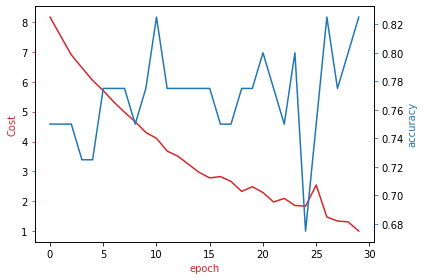

In [32]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)

ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

<h2>Testing</h2>


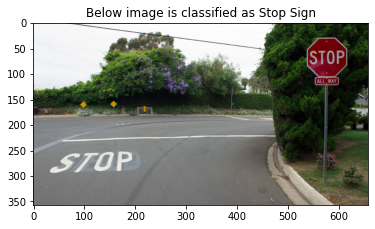

In [45]:
# Answer for the first question
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalize using computed mean and std
])

directory = "C:/Users/ASUS/Documents/Coursera/Coursera Specialization/IBM AI Engineering/Intro to Computer Vision and Image Processing/Peer-Graded Assignment/Data/"
positive = "Stop"
negative = "NoStop"

image_1 = Image.open(directory+positive+'/4.png')
img = transform(image_1)

with torch.no_grad():  # No need to compute gradients for inference
    output = model(img)
    _, predicted = torch.max(output, 1)  # Get the index of the max value

plt.imshow(image_1)
if np.array(predicted) == 1:
    plt.title('Below image is classified as Stop Sign')
else:
    plt.title('Below image is classified as No Stop Sign')

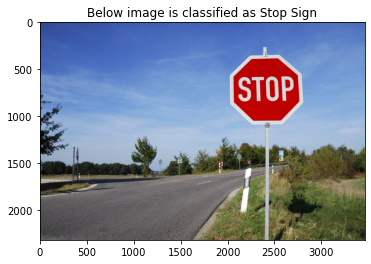

In [46]:
# Answer for the second question
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalize using computed mean and std
])

directory = "C:/Users/ASUS/Documents/Coursera/Coursera Specialization/IBM AI Engineering/Intro to Computer Vision and Image Processing/Peer-Graded Assignment/Data/"
positive = "Stop"
negative = "NoStop"

image_2 = Image.open(directory+positive+'/2.jpg')
img = transform(image_2)

with torch.no_grad():  # No need to compute gradients for inference
    output = model(img)
    _, predicted = torch.max(output, 1)  # Get the index of the max value

plt.imshow(image_2)
if np.array(predicted) == 1:
    plt.title('Below image is classified as Stop Sign')
else:
    plt.title('Below image is classified as No Stop Sign')

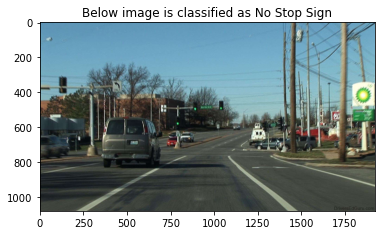

In [48]:
# Answer for the fifth question
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalize using computed mean and std
])

directory = "C:/Users/ASUS/Documents/Coursera/Coursera Specialization/IBM AI Engineering/Intro to Computer Vision and Image Processing/Peer-Graded Assignment/Data/"
positive = "Stop"
negative = "NoStop"

image_1_nostop = Image.open(directory+negative+'/2.jpg')
img = transform(image_1_nostop)

with torch.no_grad():  # No need to compute gradients for inference
    output = model(img)
    _, predicted = torch.max(output, 1)  # Get the index of the max value

plt.imshow(image_1_nostop)
if np.array(predicted) == 1:
    plt.title('Below image is classified as Stop Sign')
else:
    plt.title('Below image is classified as No Stop Sign')

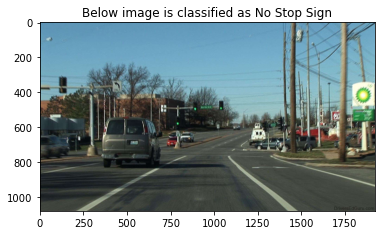

In [49]:
# Answer for the fifth question
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())  # Normalize using computed mean and std
])

directory = "C:/Users/ASUS/Documents/Coursera/Coursera Specialization/IBM AI Engineering/Intro to Computer Vision and Image Processing/Peer-Graded Assignment/Data/"
positive = "Stop"
negative = "NoStop"

image_2_nostop = Image.open(directory+negative+'/21.jpg')
img = transform(image_2_nostop)

with torch.no_grad():  # No need to compute gradients for inference
    output = model(img)
    _, predicted = torch.max(output, 1)  # Get the index of the max value

plt.imshow(image_1_nostop)
if np.array(predicted) == 1:
    plt.title('Below image is classified as Stop Sign')
else:
    plt.title('Below image is classified as No Stop Sign')

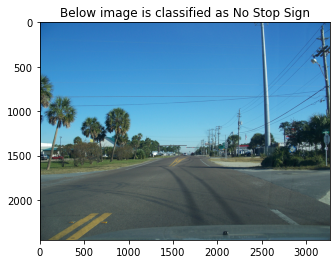

In [30]:
# Answer for the seventh question
image_size = 150
transform = transforms.Compose(([transforms.Resize((image_size, image_size)), transforms.PILToTensor()]))

image_3_nostop = Image.open(data_dir_nostop+'/103.jpg')
image_transformed_3_nostop = transform(image_3_nostop)
img = image_transformed_3_nostop/255
img = img.unsqueeze(0)

with torch.no_grad():  # No need to compute gradients for inference
    output = model(img)
    _, predicted = torch.max(output, 1)  # Get the index of the max value

plt.imshow(image_3_nostop)
if np.array(predicted) == 1:
    plt.title('Below image is classified as Stop Sign')
else:
    plt.title('Below image is classified as No Stop Sign')

<h2>Use Pre-Trained Model</h2>


In [35]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3]),                    
            transforms.Normalize(mean, std)])

transform_rotate = transforms.Compose([transforms.Resize((224,224)),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x[:3]),                    
            transforms.Normalize(mean, std)])

train_dataset_new = Dataset(transform=transform_rotate,train=True)
validation_dataset_new = Dataset(transform=transform,train=False)

(224, 224, 3)


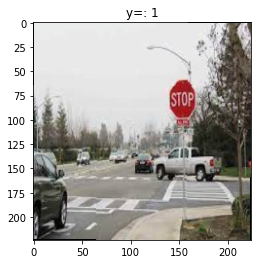

(224, 224, 3)


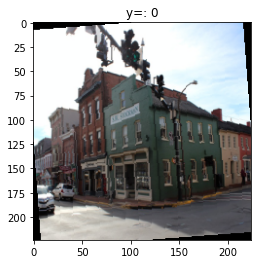

(224, 224, 3)


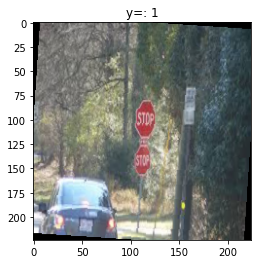

(224, 224, 3)


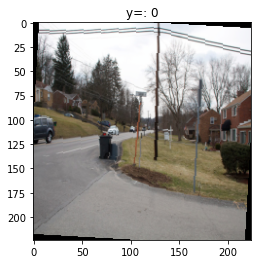

(224, 224, 3)


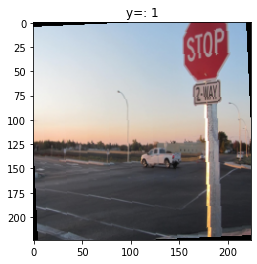

(224, 224, 3)


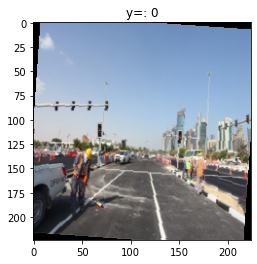

(224, 224, 3)


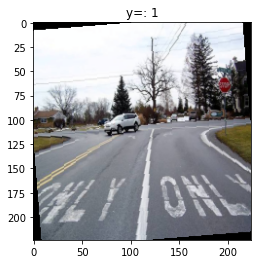

(224, 224, 3)


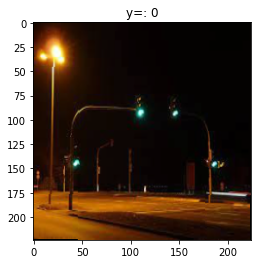

(224, 224, 3)


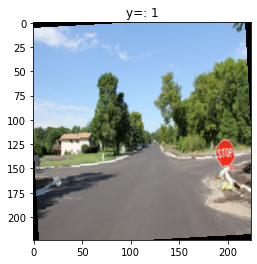

(224, 224, 3)


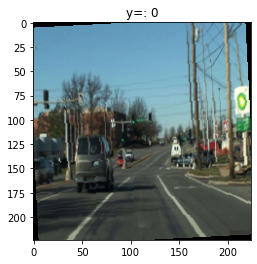

In [36]:
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

i = 0

for x, y in train_dataset_new:
    imshow_(x, "y=: {}".format(str(y.item())))
    i += 1
    if i == 10:
        break

In [37]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_new, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset_new, batch_size=1)

In [38]:
import torchvision.models as models

model = models.resnet18(pretrained=True)

# Type your code here
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512,2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

<h2>Train the model</h2>


In [39]:
def train_model(
    model, train_loader, validation_loader, criterion, optimizer, n_epochs, print_=True
):
    loss_list = []
    accuracy_list = []
    correct = 0
    # global:val_set
    n_test = len(validation_dataset)
    accuracy_best = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
    # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            model.train()

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch))

        scheduler.step()
        loss_list.append(np.mean(loss_sublist))
        correct = 0

        for x_test, y_test in validation_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy > accuracy_best:
            accuracy_best = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        if print_:
            print("learning rate", optimizer.param_groups[0]["lr"])
            print(
                "The validaion  Cost for each epoch "
                + str(epoch + 1)
                + ": "
                + str(np.mean(loss_sublist))
            )
            print(
                "The validation accuracy for epoch "
                + str(epoch + 1)
                + ": "
                + str(accuracy)
            )
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model

In [40]:
lr_scheduler = True
base_lr = 0.001
max_lr = 0.01

In [41]:
from torch.optim import lr_scheduler

if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer, base_lr=0.001, max_lr=0.01, step_size_up=5, mode="triangular2"
    )

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


In [43]:
from datetime import datetime
import time
import copy
from tqdm import tqdm

start_datetime = datetime.now()
start_time = time.time()

accuracy_list, loss_list, model = train_model(
    model, train_loader, validation_loader, criterion, optimizer, n_epochs=10
)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time)

The first epoch should take several minutes


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

epoch 0 done


 10%|████████▎                                                                          | 1/10 [00:31<04:39, 31.10s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 0.932288313905398
The validation accuracy for epoch 1: 0.7
epoch 1 done


 20%|████████████████▌                                                                  | 2/10 [01:01<04:05, 30.63s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.515744445224603
The validation accuracy for epoch 2: 0.875
epoch 2 done


 30%|████████████████████████▉                                                          | 3/10 [01:33<03:39, 31.39s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.38569484154383343
The validation accuracy for epoch 3: 0.875
epoch 3 done


 40%|█████████████████████████████████▏                                                 | 4/10 [02:04<03:05, 30.97s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.24035953838999072
The validation accuracy for epoch 4: 0.85
epoch 4 done


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:34<02:33, 30.72s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.2921766738096873
The validation accuracy for epoch 5: 0.85
epoch 5 done


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:03<02:00, 30.20s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.1947818996074299
The validation accuracy for epoch 6: 0.925
epoch 6 done


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:32<01:29, 29.71s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.2744035944342613
The validation accuracy for epoch 7: 0.95
epoch 7 done


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:00<00:58, 29.38s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.2555619416137536
The validation accuracy for epoch 8: 1.0
epoch 8 done


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:30<00:29, 29.40s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.13714176851014295
The validation accuracy for epoch 9: 0.925
epoch 9 done


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:02<00:00, 30.27s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.13503002561628819
The validation accuracy for epoch 10: 0.975
elapsed time 302.75454211235046


<h2>Plot the loss and accuracy</h2>


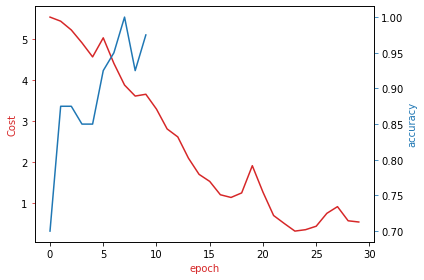

In [44]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()